In [1]:
import pandas as pd
import numpy as np
from util.data_management import concate_data, load_data_raw, display_data, data_to_fft, data_adjust_scale, data_reshape_for_train
from util.data_generator_AE import DataGenerator
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn import metrics
from easydict import EasyDict

In [2]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [6]:
args = EasyDict({
    'dir_path' : r"D:\Anomaly-Dataset\sar400_vibration_data", ## 1: C:\Users\VIP444\Documents\Anomaly-Dataset, 2: D:\Anomaly-Dataset\sar400_vibration_data
    'is_normal' : True,
    'is_train' : True,
    'stop_idx' : 2,
    'data_scale_fit' : True,
    'data_scale_trans' : False,
    'batch_size' : 128,
    'split' : (0.9, 0.1),
    'is_cache' : True,
    'is_normalize' : False,
    'is_lstm' : True
})

In [ ]:
train_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Train',
    batch_size=args.batch_size,
    split=args.split,
    is_train=args.is_train,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

validation_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Validation',
    batch_size=args.batch_size,
    split=args.split,
    is_train=args.is_train,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

test_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Test',
    batch_size=args.batch_size,
    split=args.split,
    is_train=False,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

In [ ]:
print(len(train_dataset.data_paths))
print(len(validation_dataset.data_paths))

 20%|██        | 2/10 [01:02<04:09, 31.15s/it]


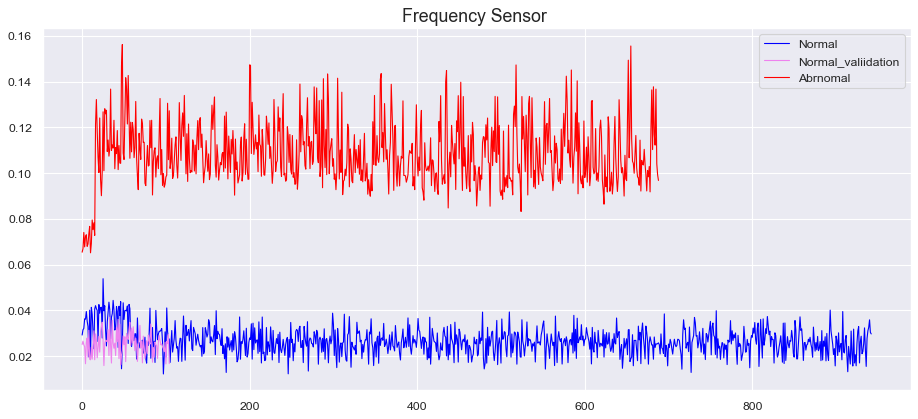

In [7]:
train_data_0, train_data_1, train_data_2, train_data_3, validation_data_0, validation_data_1, validation_data_2, validation_data_3 = load_data_raw(
    dir_path=args.dir_path, 
    is_normal=args.is_normal, 
    is_train=args.is_train, 
    stop_idx=args.stop_idx
    )

test_data_0, test_data_1, test_data_2, test_data_3 = load_data_raw(
    dir_path=args.dir_path,
    is_normal=False,
    is_train=False,
    stop_idx=args.stop_idx
)

display_data(train_data_0, validation_data_0, test_data_0)

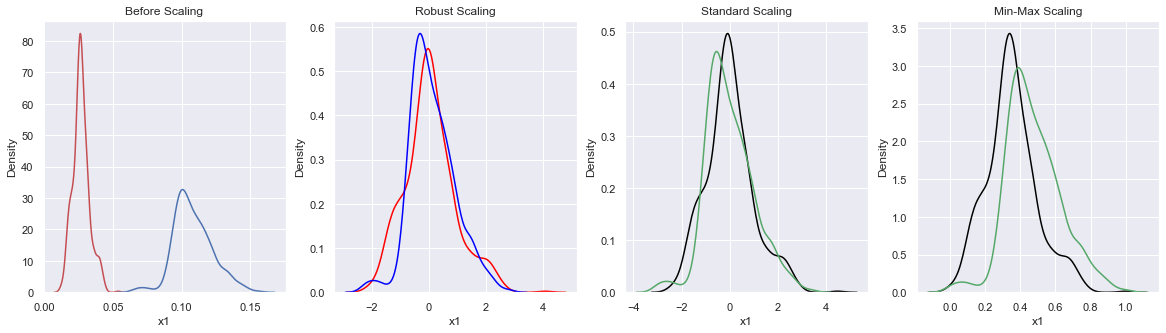

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

train_data_0 = train_data_0[:len(test_data_0)]

x = pd.DataFrame({
    'x1': train_data_0.squeeze(-1),
    'x2': test_data_0.squeeze(-1),
    })

scaler = RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['x1', 'x2'])

scaler = StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['x1', 'x2'])

scaler = MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['x1', 'x2'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['x1'], ax = ax1, color ='r')
sns.kdeplot(x['x2'], ax = ax1, color ='b')
ax2.set_title('Robust Scaling')

sns.kdeplot(robust_df['x1'], ax = ax2, color ='red')
sns.kdeplot(robust_df['x2'], ax = ax2, color ='blue')
ax3.set_title('Standard Scaling')

sns.kdeplot(standard_df['x1'], ax = ax3, color ='black')
sns.kdeplot(standard_df['x2'], ax = ax3, color ='g')
ax4.set_title('Min-Max Scaling')

sns.kdeplot(minmax_df['x1'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['x2'], ax = ax4, color ='g')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('Scaler', StandardScaler())])

X_train_0 = data_adjust_scale(pipeline, train_data_0, args.data_scale_fit)
X_train_1 = data_adjust_scale(pipeline, train_data_1, args.data_scale_trans)
X_train_2 = data_adjust_scale(pipeline, train_data_2, args.data_scale_trans)
X_train_3 = data_adjust_scale(pipeline, train_data_3, args.data_scale_trans)

X_validation_0 = data_adjust_scale(pipeline, validation_data_0, args.data_scale_trans)
X_validation_1 = data_adjust_scale(pipeline, validation_data_1, args.data_scale_trans)
X_validation_2 = data_adjust_scale(pipeline, validation_data_2, args.data_scale_trans)
X_validation_3 = data_adjust_scale(pipeline, validation_data_3, args.data_scale_trans)

X_test_0 = data_adjust_scale(pipeline, test_data_0, args.data_scale_trans)
X_test_1 = data_adjust_scale(pipeline, test_data_1, args.data_scale_trans)
X_test_2 = data_adjust_scale(pipeline, test_data_2, args.data_scale_trans)
X_test_3 = data_adjust_scale(pipeline, test_data_3, args.data_scale_trans)

display_data(X_train_0, X_validation_0, X_test_0)

In [ ]:
X_train = concate_data((X_train_0, X_train_1, X_train_2, X_train_3), 1)
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), 1)
X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), 1)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

X_train = data_reshape_for_train(X_train_0, X_train_1, X_train_2, X_train_3)
X_validation = data_reshape_for_train(X_validation_0, X_validation_1, X_validation_2, X_validation_3)
X_test = data_reshape_for_train(X_test_0, X_test_1, X_test_2, X_test_3)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

In [ ]:
from models.ae_LSTM import autoencoder_model
# from models.ae_Dense import autoencoder_model
from tensorflow.keras.optimizers import Adam

if args.is_lstm:
    input_shape = (1, 4)
else:
    input_shape = (4, )

model = autoencoder_model(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mae')
model.summary()

In [ ]:
epochs = 2

checkpoint_path = "model/checkpoint.pt"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1), 
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6,verbose=1,min_lr=1e-3 * 1e-1),
    CSVLogger('./train_log.csv', separator=',', append=True),
    ]

import time

start = time.time()
# history = model.fit(X_train, X_train, epochs=epochs, batch_size=args.batch_size, callbacks=callbacks, validation_data=(X_validation, X_validation)).history
history = model.fit(train_dataset, validation_data=(validation_dataset), epochs=epochs, batch_size=args.batch_size, callbacks=callbacks).history
end = time.time()

print(f"{end-start:.5f} sec")

model.load_weights(checkpoint_path)
model.save("model/model_concate.h5")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train_loss', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation_loss', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
loss = model.evaluate(test_dataset, verbose=1)
print(loss)

In [ ]:
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), axis=1)
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])

# model = tf.keras.models.load_model('model/model_concate.h5')
predictons_3d = model.predict(X_validation)
predictions = predictons_3d.reshape(predictons_3d.shape[0], predictons_3d.shape[2])
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
mse = np.mean(np.power(X_validation - predictions, 2), axis=1)

y_valid = np.ones(len(X_validation))

error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class': y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]

print(precision_rt[np.argmin(best_cnt_dic)])
print(recall_rt[np.argmin(best_cnt_dic)])
print(threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('model/model_concate.h5')

X_pred = model.predict(X_train)

X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
X_pred = pd.DataFrame(X_pred)

Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) 

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
# scored['Loss_mae'] = np.mean(X_pred-Xtrain, axis=1) 

Threshold = 0.017

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
plt.xlim([0,1])
sns.distplot(scored['Loss_mae'], kde= True, color = 'blue')

In [ ]:
X_pred = model.predict(test_dataset)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

print(X_pred)

Threshold = 0.3

# scored = pd.DataFrame()
# Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
# scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
# scored['Threshold'] = Threshold
# scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
# print(scored)

# scored.to_csv('./test_log.csv', sep=',')

In [ ]:
# X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])
X_pred_val = model.predict(validation_dataset)
X_pred_val = X_pred_val.reshape(X_pred_val.shape[0], X_pred_val.shape[2])
X_pred_val = pd.DataFrame(X_pred_val)

print(X_pred_val)

# scored_val = pd.DataFrame()
# Xvalidation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
# scored_val['Loss_mae'] = np.mean(np.abs(X_pred_val-Xvalidation), axis=1)
# scored_val['Threshold'] = Threshold
# scored_val['Anomaly'] = scored_val['Loss_mae'] > scored_val['Threshold']
# print(scored_val)
# scored_val.to_csv('./validation_log.csv', sep=',')

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./train_log.csv', sep=',')